# Fractal VR TMT analysis. (in R)


This notebook is running behavioral analysis of Fractal VR data. 


Only needed to be done once:

In [ ]:
packages <- c(
  "ez", "emmeans", "cowplot", "dplyr", "readr", "ggplot2", "lmerTest", 
  "hrbrthemes", "sjPlot", "sjmisc", "sjlabelled", "tidyr", "tidyverse", 
  "ggthemes", "ggpubr", "knitr", "jtools", "apaTables", "psych", "boot"
)

install.packages(packages)

In [103]:
# load libraries
library(ez)
citation("ez")
library(emmeans)
citation("emmeans")

# Plotting and formatting
library(cowplot)
library(dplyr)
library(readr) 
library(ggplot2)
#library(lmerTest)
library(hrbrthemes)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
# Raincloud plot( from https://github.com/RainCloudPlots/RainCloudPlots):
# this file needs to be in the same directory as the script
source('R_rainclouds.R')
library(tidyr)
library(tidyverse)
library(ggthemes)
library(ggpubr)
# Formatting
library(knitr)
library(jtools)
library(apaTables)
# Reliability
library(psych)
library(tidyr)
library(boot)


To cite package ‘ez’ in publications use:

  Lawrence MA (2016). _ez: Easy Analysis and Visualization of Factorial
  Experiments_. R package version 4.4-0,
  <https://CRAN.R-project.org/package=ez>.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {ez: Easy Analysis and Visualization of Factorial Experiments},
    author = {Michael A. Lawrence},
    year = {2016},
    note = {R package version 4.4-0},
    url = {https://CRAN.R-project.org/package=ez},
  }

ATTENTION: This citation information has been auto-generated from the
package DESCRIPTION file and may need manual editing, see
‘help("citation")’.

To cite package ‘emmeans’ in publications use:

  Lenth R (2023). _emmeans: Estimated Marginal Means, aka Least-Squares
  Means_. R package version 1.8.9,
  <https://CRAN.R-project.org/package=emmeans>.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {emmeans: Estimated Marginal Means, aka Least-Squares Means},
    author = {Russell V. Lenth},
    year = {2023},
    note = {R package version 1.8.9},
    url = {https://CRAN.R-project.org/package=emmeans},
  }

### Functions

Helper functions that help organise and analyse the data

In [104]:
load_tmt <- function(subjects, root) {
  # Predefined column names
  data_columns <- c("subject", "date", "block", "trial", "order", "condition", 
                    "trigger_time", "start_time", "end_time", "duration", 
                    "accuracy", "attempts", "errors", "avg_line_length", 
                    "shortest_path", "relative_length", "response_order")
  
  # Create empty data frames with predefined column names
  data_collective <- data.frame(matrix(ncol = length(data_columns), nrow = 0))
  colnames(data_collective) <- data_columns
  
  path_collective <- data.frame()
  
  # Loop through the subjects
  for (i in 1:length(subjects)) {
    # Construct the paths to the data files
    data_path <- paste0(root, subjects[i], "_TMT_behavior.csv")
    path_path <- paste0(root, subjects[i], "_TMT_paths.csv")
    #print(subjects[i])
    # Load the data without row names
    # Load the data without row names
    data_tmt <- read.csv(data_path,row.names = NULL, sep = ",",dec = ".",stringsAsFactors = FALSE, header = TRUE)
    #print(data_tmt)
    path_tmt <- read.csv(path_path, row.names = NULL,sep = ",")
    
    # Remove the row.names and X columns if they exist
    data_tmt <- data_tmt[, !names(data_tmt) %in% c("X")]
    
    # Add the subject id
    #data_tmt$subject <- subjects[i]
    path_tmt$subject <- subjects[i]

    # Ensure all columns are present
    missing_cols <- setdiff(data_columns, names(data_tmt))
    if (length(missing_cols) > 0) {
      for (col in missing_cols) {
        data_tmt[[col]] <- NA
      }
    }
    data_tmt <- data_tmt[, data_columns]
    
    # Ensure column names match for data_tmt
    if (!all(names(data_collective) == names(data_tmt))) {
      print("Column names of data_collective:")
      print(names(data_collective))
      print("Column names of data_tmt:")
      print(names(data_tmt))
      stop("Column names of data_tmt do not match data_collective")
    }
    data_collective <- rbind(data_collective, data_tmt)
    
    if (nrow(path_collective) == 0) {
      path_collective <- path_tmt
    } else {
      # Standardize column names
      common_cols <- intersect(names(path_collective), names(path_tmt))
      path_collective <- path_collective[, common_cols, drop = FALSE]
      path_tmt <- path_tmt[, common_cols, drop = FALSE]
      
      if (!all(names(path_collective) == names(path_tmt))) {
        print("Column names of path_collective:")
        print(names(path_collective))
        print("Column names of path_tmt:")
        print(names(path_tmt))
        stop("Column names of path_tmt do not match path_collective")
      }
      path_collective <- rbind(path_collective, path_tmt)
    }
  }
  
  return(list(data = data_collective, path = path_collective))
}

In [105]:
# Root for the data
root <- '/users/sztuka/Documents/FractalVR/data/'

subjects <- list.files(root, pattern = "_TMT_behavior.csv") 
# list only sub-XXX names with no extensions
subjects <- gsub("_TMT_behavior.csv", "", subjects)
print(subjects)
# unique only

result <- load_tmt(subjects, root)

# Access the loaded data
data_collective <- result$data
path_collective <- result$path

#Exclude all rows sub_Z2CN1H sub_YG0DT2, subject, JGMJ5O
data_collective <- data_collective[!(data_collective$subject %in% c("Z2CN1H", "YG0DT2", "JGMJ5P","subject")),]
n_subjects <- length(unique(data_collective$subject))
cat("Number of subjects: ", n_subjects, "\n")

 [1] "sub_0FJ87G" "sub_1L9FCD" "sub_AAU5L2" "sub_E3R3C1" "sub_FA5FCX"
 [6] "sub_JGMJ5P" "sub_KQT35L" "sub_KWCTKJ" "sub_MNQJJL" "sub_MX16R1"
[11] "sub_N6FGR8" "sub_PVAA50" "sub_RJ70HQ" "sub_V4JN59" "sub_VVXYJ5"
[16] "sub_YG0DT2" "sub_Z2CN1H" "sub_Z6WJKG"
Number of subjects:  15 


In [106]:
# nuber of rows
nrow(data_collective)


[1] 390

In [107]:
# filter by accuracy less than 0.2 - removing outliers
data_collective2 <- data_collective #[data_collective$accuracy > 0.2,]

In [130]:
#  Create new columns for TMT_type, S/E or L/M/H if condition includes A then TMT_type is A if B then TMT_type is B, if contains S then S/E is S if E then S/E is E, if contains L then L/M/H is L if M then L/M/H is M if H then L/M/H is H

data_collective2$TMT_type <- ifelse(grepl("A", data_collective2$condition), "A", 
                                    ifelse(grepl("B", data_collective2$condition), "B", "baseline"))

data_collective2$S_E <- ifelse(grepl("S", data_collective2$condition), "Statistical",
                                ifelse(grepl("E", data_collective2$condition), "Extact", "baseline"))    
                            
data_collective2$L_M_H <- ifelse(grepl("L", data_collective2$condition), "Low",
                                ifelse(grepl("M", data_collective2$condition), "Medium",
                                ifelse(grepl("H", data_collective2$condition), "High", "baseline")))

# convert duration from ch to numeric

data_collective2$duration <- as.numeric(data_collective2$duration)
# accuracy from character to numeric
data_collective2$accuracy <- as.numeric(data_collective2$accuracy)
# conver avg_line_length from character to numeric
data_collective2$avg_line_length <- as.numeric(data_collective2$avg_line_length)


In [131]:
# count instances of subject and print it

for (i in unique(data_collective2$subject)) {
  cat(i, ":", sum(data_collective2$subject == i), "\n")
}

0FJ87G : 26 
1L9FCD : 26 
AAU5L2 : 26 
E3R3C1 : 26 
FA5FCX : 26 
KQT35L : 26 
KWCTKJ : 26 
MNQJJL : 26 
MX16R1 : 26 
N6FGR8 : 26 
PVAA50 : 26 
RJ70HQ : 26 
V4JN59 : 26 
VVXYT5 : 26 
Z6WJKG : 26 


Warning message:
“Converting "subject" to factor for ANOVA.”
Warning message:
“Converting "S_E" to factor for ANOVA.”
Warning message:
“Converting "L_M_H" to factor for ANOVA.”
Warning message:
“Converting "TMT_type" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”




|   |Effect             | DFn| DFd|           F|         p|p<.05 |       ges|
|:--|:------------------|---:|---:|-----------:|---------:|:-----|---------:|
|2  |S_E                |   1|  14|   0.4946728| 0.4933818|      | 0.0018724|
|3  |L_M_H              |   2|  28|   1.5002239| 0.2404700|      | 0.0114285|
|4  |TMT_type           |   1|  14| 121.8857884| 0.0000000|*     | 0.3926742|
|5  |S_E:L_M_H          |   2|  28|   0.6712405| 0.5191069|      | 0.0026375|
|6  |S_E:TMT_type       |   1|  14|   0.4057024| 0.5344363|      | 0.0017917|
|7  |L_M_H:TMT_type     |   2|  28|   3.6946623| 0.0376704|*     | 0.0184560|
|8  |S_E:L_M_H:TMT_type |   2|  28|   0.1158702| 0.8910156|      | 0.0006249|

|   |Effect             |         W|         p|p<.05 |
|:--|:------------------|---------:|---------:|:-----|
|3  |L_M_H              | 0.9418825| 0.6776082|      |
|5  |S_E:L_M_H          | 0.9433554| 0.6845256|      |
|7  |L_M_H:TMT_type     | 0.8268468| 0.2905780|      |
|8  |S_E:L_M_H:TMT_t



|contrast                              |TMT_type |   estimate|       SE|       df|    t.ratio|   p.value|
|:-------------------------------------|:--------|----------:|--------:|--------:|----------:|---------:|
|Extact High - Statistical High        |A        |  2.0601791| 1.312902| 326.0001|  1.5691801| 0.6194925|
|Extact High - Extact Low              |A        |  1.3100922| 1.312902| 326.0001|  0.9978602| 0.9184257|
|Extact High - Statistical Low         |A        |  1.6446829| 1.312902| 326.0001|  1.2527084| 0.8102738|
|Extact High - Extact Medium           |A        |  1.0377916| 1.312902| 326.0001|  0.7904565| 0.9690231|
|Extact High - Statistical Medium      |A        |  1.8644554| 1.312902| 326.0001|  1.4201029| 0.7148063|
|Statistical High - Extact Low         |A        | -0.7500868| 1.312902| 326.0001| -0.5713199| 0.9928125|
|Statistical High - Statistical Low    |A        | -0.4154962| 1.312902| 326.0001| -0.3164717| 0.9995750|
|Statistical High - Extact Medium      |A   


	Welch Two Sample t-test

data:  duration by S_E
t = 1.6101, df = 172.99, p-value = 0.1092
alternative hypothesis: true difference in means between group Extact and group Statistical is not equal to 0
95 percent confidence interval:
 -0.2425236  2.3901460
sample estimates:
     mean in group Extact mean in group Statistical 
                 20.79588                  19.72207 



	Welch Two Sample t-test

data:  duration by S_E
t = 0.067908, df = 169.03, p-value = 0.9459
alternative hypothesis: true difference in means between group Extact and group Statistical is not equal to 0
95 percent confidence interval:
 -2.417227  2.589455
sample estimates:
     mean in group Extact mean in group Statistical 
                 30.11043                  30.02432 


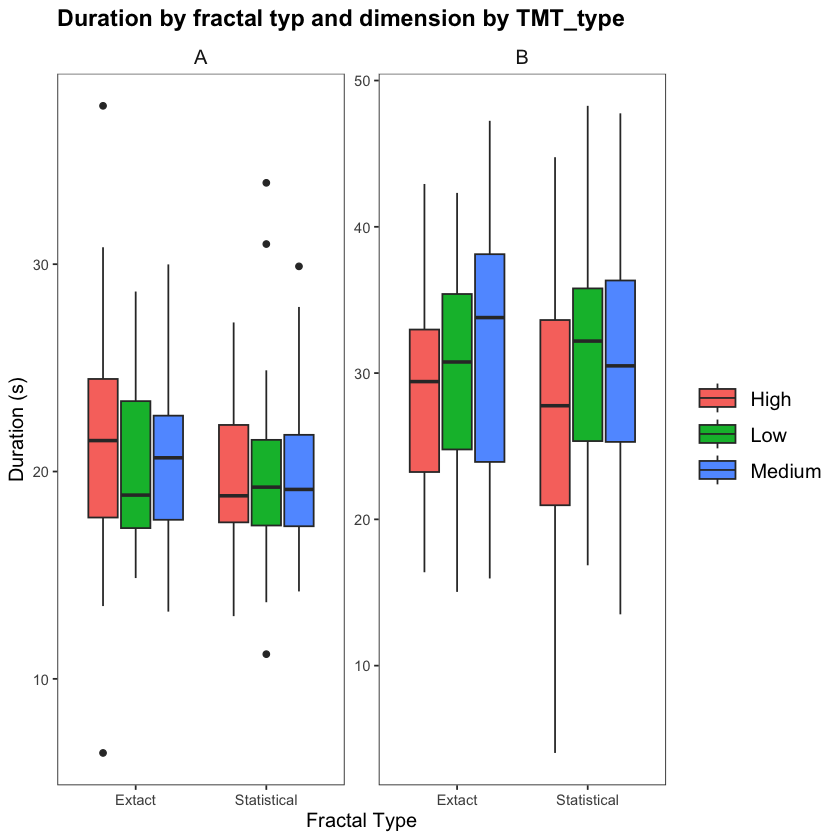

In [152]:
# plot the duration data by S_E and L_M_H facet by TMT_type

# remove baseline
data_collective_nobaseline <- data_collective2[data_collective2$TMT_type != "baseline",]

# remove outlivers more than 2.5 SD
data_collective_nobaseline <- data_collective_nobaseline[!(data_collective_nobaseline$duration > mean(data_collective_nobaseline$duration) + 2.5 * sd(data_collective_nobaseline$duration)),]

# plot the duration data by S_E and L_M_H facet by TMT_type via raincloud plot

p <- ggplot(data = data_collective_nobaseline, aes(x = S_E, y = duration, fill = L_M_H)) +
  geom_boxplot() +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "top") +
  facet_wrap(~TMT_type, scales = "free_y") +
  theme_apa() +
  labs(x = "Fractal Type", y = "Duration (s)", title = "Duration by fractal type and dimension by TMT_type")

p

# anova for duration

duration_anova <- ezANOVA(data = data_collective_nobaseline, dv = duration, wid = subject, within = .(S_E, L_M_H, TMT_type))
# knit table
knitr::kable(duration_anova)
# apa style for publication
# apa.ezANOVA.table(duration_anova)

# Pairwise comparisons for duration by TMT_type
# Include TMT_type in the model
model <- lmer(duration ~ S_E * L_M_H * TMT_type + (1 | subject), data = data_collective_nobaseline)
emmeans_model <- emmeans(model, ~ S_E * L_M_H | TMT_type)
pairwise_results <- pairs(emmeans_model)

# Print pairwise comparison results
knitr::kable(pairwise_results)


# t-test for duration by S_E on duration by TMT_type

# TMT_type A

ttest_A <- t.test(duration ~ S_E, data = data_collective_nobaseline[data_collective_nobaseline$TMT_type == "A",])
# TMT_type B
ttest_B <- t.test(duration ~ S_E, data = data_collective_nobaseline[data_collective_nobaseline$TMT_type == "B",])

# Print t-test results
ttest_A
ttest_B


# LMER duration ~ S_E * L_M_H * TMT_type + (1 | subject)
model <- lmer(duration ~ S_E * L_M_H * TMT_type + (1 | subject), data = data_collective_nobaseline)

tab_model(model)

Warning message:
“Converting "subject" to factor for ANOVA.”
Warning message:
“Converting "S_E" to factor for ANOVA.”
Warning message:
“Converting "L_M_H" to factor for ANOVA.”
Warning message:
“Converting "TMT_type" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”




|   |Effect             | DFn| DFd|         F|         p|p<.05 |       ges|
|:--|:------------------|---:|---:|---------:|---------:|:-----|---------:|
|2  |S_E                |   1|  14| 0.0050030| 0.9446114|      | 0.0000377|
|3  |L_M_H              |   2|  28| 0.3877175| 0.6821908|      | 0.0040542|
|4  |TMT_type           |   1|  14| 0.3313269| 0.5740151|      | 0.0018427|
|5  |S_E:L_M_H          |   2|  28| 0.4599183| 0.6360200|      | 0.0031293|
|6  |S_E:TMT_type       |   1|  14| 0.2005092| 0.6611610|      | 0.0006301|
|7  |L_M_H:TMT_type     |   2|  28| 0.3959615| 0.6767418|      | 0.0028805|
|8  |S_E:L_M_H:TMT_type |   2|  28| 1.7666214| 0.1894312|      | 0.0098060|

|   |Effect             |         W|         p|p<.05 |
|:--|:------------------|---------:|---------:|:-----|
|3  |L_M_H              | 0.7973441| 0.2294550|      |
|5  |S_E:L_M_H          | 0.6200738| 0.0447592|*     |
|7  |L_M_H:TMT_type     | 0.9059089| 0.5260770|      |
|8  |S_E:L_M_H:TMT_type | 0.8959745| 0



|contrast                              |TMT_type |   estimate|        SE|       df|    t.ratio|   p.value|
|:-------------------------------------|:--------|----------:|---------:|--------:|----------:|---------:|
|Extact High - Statistical High        |A        | -0.0506667| 0.0588034| 326.0005| -0.8616279| 0.9552395|
|Extact High - Extact Low              |A        | -0.0826667| 0.0588034| 326.0005| -1.4058140| 0.7235336|
|Extact High - Statistical Low         |A        | -0.0653333| 0.0588034| 326.0005| -1.1110466| 0.8766408|
|Extact High - Extact Medium           |A        | -0.0413333| 0.0588034| 326.0005| -0.7029070| 0.9815140|
|Extact High - Statistical Medium      |A        | -0.0453333| 0.0588034| 326.0005| -0.7709303| 0.9722121|
|Statistical High - Extact Low         |A        | -0.0320000| 0.0588034| 326.0005| -0.5441861| 0.9942699|
|Statistical High - Statistical Low    |A        | -0.0146667| 0.0588034| 326.0005| -0.2494186| 0.9998680|
|Statistical High - Extact Medium  

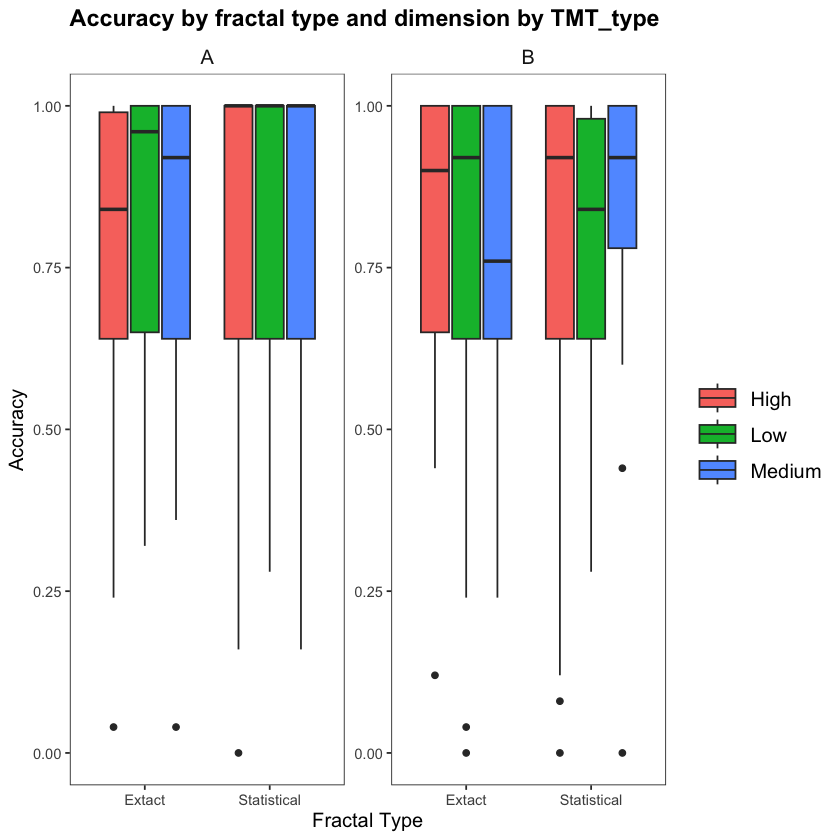

In [153]:
# accuracy 

# plot the accuracy data by S_E and L_M_H facet by TMT_type data_collective_nobaseline

r <- ggplot(data = data_collective_nobaseline, aes(x = S_E, y = accuracy, fill = L_M_H)) +
  geom_boxplot() +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "top") +
  facet_wrap(~TMT_type, scales = "free_y") +
  theme_apa() +
  labs(x = "Fractal Type", y = "Accuracy", title = "Accuracy by fractal type and dimension by TMT_type")

r

# anova for accuracy

accuracy_anova <- ezANOVA(data = data_collective_nobaseline, dv = accuracy, wid = subject, within = .(S_E, L_M_H, TMT_type))
# knit table
knitr::kable(accuracy_anova)

# Pairwise comparisons for accuracy by TMT_type
# Include TMT_type in the model
model <- lmer(accuracy ~ S_E * L_M_H * TMT_type + (1 | subject), data = data_collective_nobaseline)
emmeans_model <- emmeans(model, ~ S_E * L_M_H | TMT_type)
pairwise_results <- pairs(emmeans_model)

# Print pairwise comparison results
knitr::kable(pairwise_results)

tab_model(model)

In [156]:
data_collective_nobaseline$errors <- as.numeric(data_collective_nobaseline$errors)

Warning message:
“Converting "subject" to factor for ANOVA.”
Warning message:
“Converting "S_E" to factor for ANOVA.”
Warning message:
“Converting "L_M_H" to factor for ANOVA.”
Warning message:
“Converting "TMT_type" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”




|   |Effect             | DFn| DFd|         F|         p|p<.05 |       ges|
|:--|:------------------|---:|---:|---------:|---------:|:-----|---------:|
|2  |S_E                |   1|  14| 0.2657672| 0.6142296|      | 0.0015742|
|3  |L_M_H              |   2|  28| 0.4132081| 0.6654927|      | 0.0036439|
|4  |TMT_type           |   1|  14| 3.5984808| 0.0786549|      | 0.0336145|
|5  |S_E:L_M_H          |   2|  28| 0.0857978| 0.9180201|      | 0.0009460|
|6  |S_E:TMT_type       |   1|  14| 2.6247559| 0.1275073|      | 0.0134394|
|7  |L_M_H:TMT_type     |   2|  28| 0.2216310| 0.8026031|      | 0.0017373|
|8  |S_E:L_M_H:TMT_type |   2|  28| 0.6028832| 0.5541814|      | 0.0073497|

|   |Effect             |         W|         p|p<.05 |
|:--|:------------------|---------:|---------:|:-----|
|3  |L_M_H              | 0.8575762| 0.3683601|      |
|5  |S_E:L_M_H          | 0.8850650| 0.4522082|      |
|7  |L_M_H:TMT_type     | 0.6526569| 0.0624384|      |
|8  |S_E:L_M_H:TMT_type | 0.8596370| 0



|contrast                              |TMT_type |   estimate|        SE|       df|    t.ratio|   p.value|
|:-------------------------------------|:--------|----------:|---------:|--------:|----------:|---------:|
|Extact High - Statistical High        |A        |  1.3666667| 0.6449023| 326.0048|  2.1191840| 0.2799411|
|Extact High - Extact Low              |A        |  0.7000000| 0.6449023| 326.0048|  1.0854357| 0.8869959|
|Extact High - Statistical Low         |A        |  0.9666667| 0.6449023| 326.0048|  1.4989351| 0.6652171|
|Extact High - Extact Medium           |A        |  0.4333333| 0.6449023| 326.0048|  0.6719364| 0.9848971|
|Extact High - Statistical Medium      |A        |  0.9666667| 0.6449023| 326.0048|  1.4989351| 0.6652171|
|Statistical High - Extact Low         |A        | -0.6666667| 0.6449023| 326.0048| -1.0337483| 0.9062932|
|Statistical High - Statistical Low    |A        | -0.4000000| 0.6449023| 326.0048| -0.6202490| 0.9895020|
|Statistical High - Extact Medium  

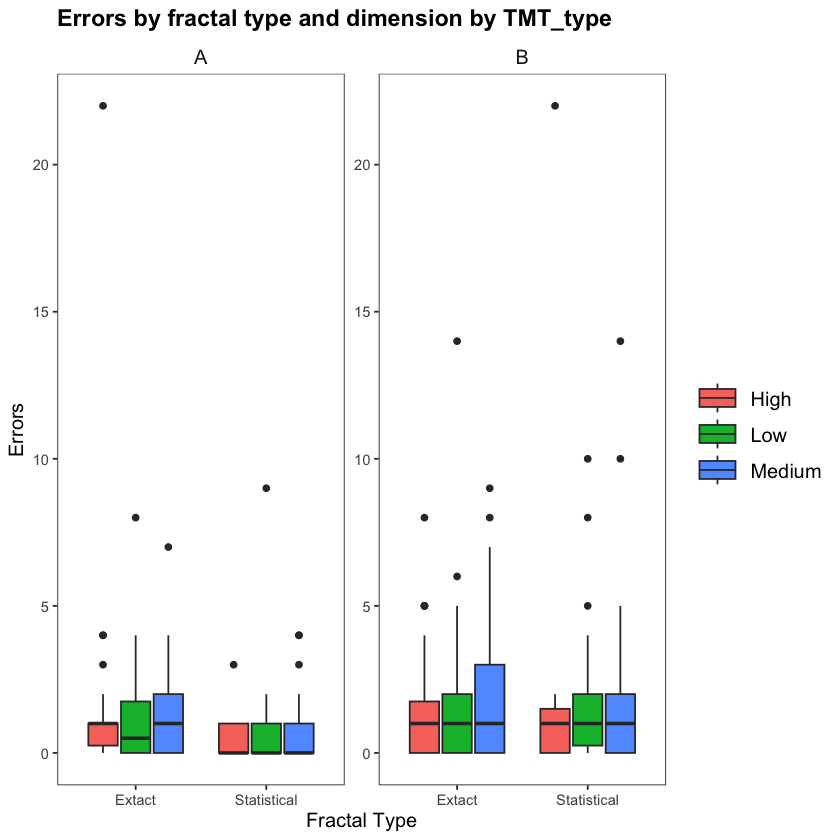

In [157]:
# do the same for errors

# plot the errors data by S_E and L_M_H facet by TMT_type data_collective_nobaseline

s <- ggplot(data = data_collective_nobaseline, aes(x = S_E, y = errors, fill = L_M_H)) +
  geom_boxplot() +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "top") +
  facet_wrap(~TMT_type, scales = "free_y") +
  theme_apa() +
  labs(x = "Fractal Type", y = "Errors", title = "Errors by fractal type and dimension by TMT_type")


s

# anova for errors
errors_anova <- ezANOVA(data = data_collective_nobaseline, dv = errors, wid = subject, within = .(S_E, L_M_H, TMT_type))
# knit table
knitr::kable(errors_anova)

# Pairwise comparisons for errors by TMT_type
# Include TMT_type in the model

model <- lmer(errors ~ S_E * L_M_H * TMT_type + (1 | subject), data = data_collective_nobaseline)
emmeans_model <- emmeans(model, ~ S_E * L_M_H | TMT_type)
pairwise_results <- pairs(emmeans_model)

# Print pairwise comparison results
knitr::kable(pairwise_results)

tab_model(model)